# Titanic case study E&Y

Data source: https://www.kaggle.com/datasets/vinicius150987/titanic3
už namergovaný dataset

Features:
    PClass - třída, hodnoty 1,2,3
    Survived - ano(1)/ne(0)
    Name - jméno
    sex - pohlaví
    age - věk
    sibsp - počet sourozenců na palubě
    parch - počet rodičů/dětí na palubě
    ticekt - číslo lístku
    fare - cena lístku
    cabin - pokoj
    embarked - přístav nalodění(C = Cherbourg, Q = Queenstown, S = Southampton)
    boat - číslo záchranného člunu (pokud survived ano)
    body - číslo vyloveného těla (survived no)
    home.dest - cílová destinace

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from scipy import stats
import tensorflow as tf
from tensorflow import keras

In [2]:
df = pd.read_excel('data/titanic3.xls')
df.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [4]:
# dropnutí Name a dalších features s velkým počtem chybějících hodnot a malou výpovědní hodnotou
df = df.drop(['name','ticket','cabin','boat','body','home.dest'], axis=1)
df['survived'] = df['survived'].replace({1 : 'yes', 0 : 'no'})
df['embarked'] = df['embarked'].replace({'S' : 'Southampton', 'C' : 'Cherbourg', 'Q' : 'Queenstown'})

In [5]:
df.describe()

,pclass,age,sibsp,parch,fare
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,29.881135,0.498854,0.385027,33.295479
std,0.837836,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,80.000000,8.000000,9.000000,512.329200


In [6]:
df.isnull().sum()

pclass        0
survived      0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

## Chybějící hodnoty
V numerických sloupcích chybějí hodnoty ve sloupcích age a fare, z kategorických proměnných chybí dvě hodnoty ve sloupci embarked
    k vyřešení tohoto problému lze přistupovat několika způsoby, viz funkce missingValues

In [7]:
def missingValues(df, approach):
    if approach == 'mean':
        df['age'] = df['age'].fillna(df['age'].mean())
        df['fare'] = df['fare'].fillna(df['fare'].mean())
        df.dropna(inplace = True)
    elif approach == 'fill':
        df['age'] = df['age'].fillna(method="ffill")
        df['fare'] = df['fare'].fillna(method="ffill")
        df = df.dropna()
    else:
        df = df.dropna()
    return df

In [8]:
df = missingValues(df,'mean')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1307 non-null   int64  
 1   survived  1307 non-null   object 
 2   sex       1307 non-null   object 
 3   age       1307 non-null   float64
 4   sibsp     1307 non-null   int64  
 5   parch     1307 non-null   int64  
 6   fare      1307 non-null   float64
 7   embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 91.9+ KB


## EDA

### distribuce hodnot
možnost zjištění zavisloti jednotlivých sloupců na cílové proměnné

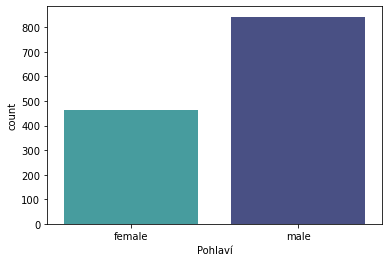

In [9]:
#cílová proměnná
sns.countplot(x='sex',data =  df, palette="mako_r")
plt.xlabel('Pohlaví')
plt.show()

In [10]:
df['sex'].value_counts()

male      843
female    464
Name: sex, dtype: int64

Cílová proměnná je nevybalancovaná -> před modelováním SMOTE

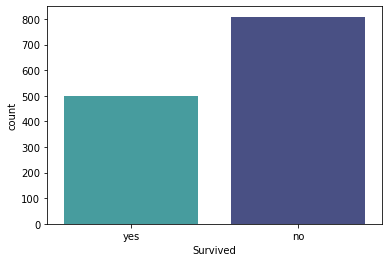

In [11]:
sns.countplot(x='survived',data =  df, palette="mako_r")
plt.xlabel('Survived')
plt.show()

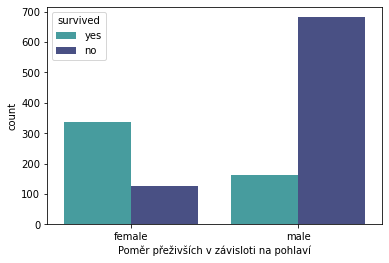

In [12]:
sns.countplot(x='sex', hue='survived',data =  df, palette="mako_r")
plt.xlabel('Poměr přeživších v závisloti na pohlaví')
plt.show()

In [13]:
df.value_counts(['sex','survived'])

sex     survived
male    no          682
female  yes         337
male    yes         161
female  no          127
dtype: int64

Velká zavislost proměnných sex a survived, většina žen přežila, zatímco u mužů tomu bylo právě naopak

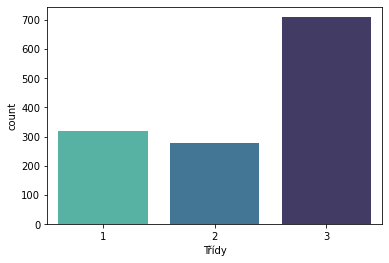

In [14]:
sns.countplot(x='pclass',data =  df, palette="mako_r")
plt.xlabel('Třídy')
plt.show()

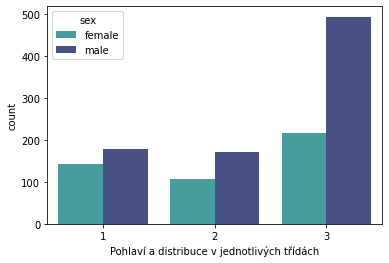

In [15]:
sns.countplot(x='pclass' ,data =  df,hue='sex', palette="mako_r")
plt.xlabel('Pohlaví a distribuce v jednotlivých třídách')
plt.show()

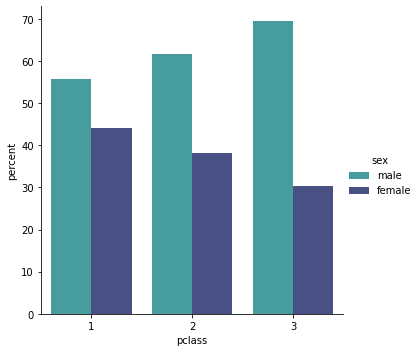

In [16]:
x,y = 'pclass', 'sex'

(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',palette="mako_r"))

Ve třetí třídě byl největší poměr mužů, který se následně snižuje

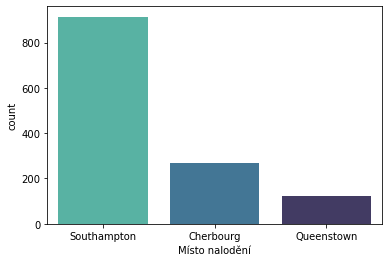

In [17]:
sns.countplot(x='embarked',data =  df, palette="mako_r")
plt.xlabel('Místo nalodění')
plt.show()

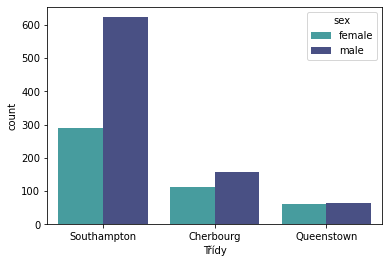

In [18]:
sns.countplot(x='embarked',data =  df,hue='sex', palette="mako_r")
plt.xlabel('Třídy')
plt.show()

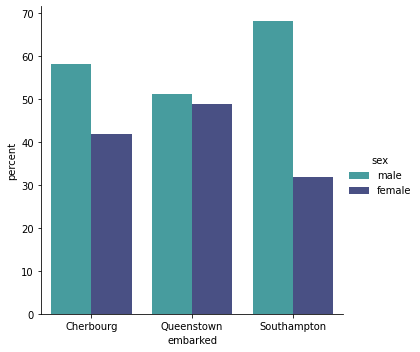

In [19]:
x,y = 'embarked', 'sex'

(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',palette="mako_r"))

I u míst nalodění můžeme vidět nepatrný vztah, například v Queenstownu se nalodilo skoro stejně žen jako mužů, naopak v Southamptonu to byla pouze třetina žen

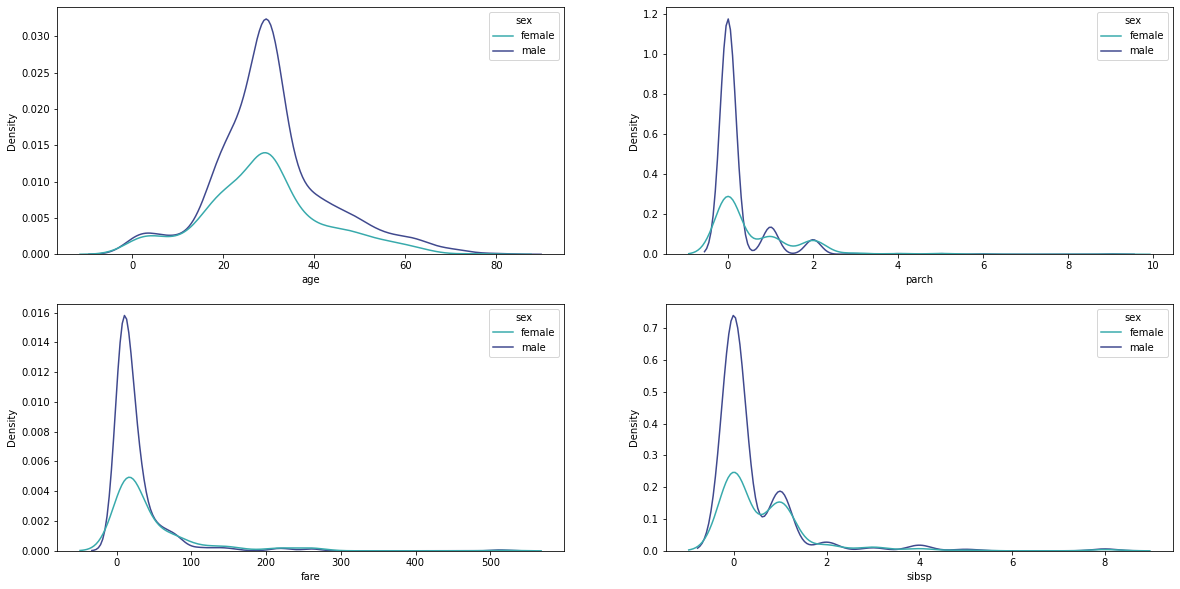

In [20]:
fig,axes=plt.subplots(2,2,figsize=(20,10))

sns.kdeplot( x=df['age'], hue=df['sex'],ax=axes[0,0],palette="mako_r")

sns.kdeplot(x=df['fare'], hue=df['sex'],ax=axes[1,0],palette="mako_r")

sns.kdeplot(x=df['parch'], hue=df['sex'], ax=axes[0,1],palette="mako_r")

sns.kdeplot(x=df['sibsp'], hue=df['sex'], ax=axes[1,1],palette="mako_r")
plt.show()

Z EDA vyplývá, že největší závislot je u proměnné survived, kde přežilo více žen než mužů. Menší trend je i u proměnné pclass a embarked, u nominálních proměnných nelze vypozorovat žádné významné trendy v závisloti na cílovou proměnnou

## Feature engineering

### Úprava dat pro potřeby modelů
Vytvoření dummy sloupců pomocí one-hot-encoder. Vyzkoušel jsem dva přístupy, kdy jsem v jednom atributy nechal a pouze pro ně vytvořil dummy proměnné, v druhém přístupu jsem zkusil z numerických sloupců vytvořit pouze booleovksé hodnoty. I přesto, že v EDA nejsou vidět žádné závisloti, tak druhý přístup přinesl horší výsledky


In [21]:
#vytvoření kopie datasetu pro Embedding NN
dfEmb = df
def encodeDf(df, keepAll):
    #první přístup pouze vytvoří pro kategorické proměnné dummy sloupce a dopne původni
    if keepAll:
        enc = OneHotEncoder(handle_unknown='error')
        enc_df = pd.DataFrame(enc.fit_transform(df[['survived','pclass','embarked']]).toarray())

        enc_df.columns = enc.get_feature_names(['survived','pclass','embarked'])

        df = df.join(enc_df)

        df = df.drop(['survived','pclass','embarked'], axis = 1)

    #druhý přístup navíc z numerických sloupců(sibsp a parch) udělá booleovské a vytvoří pro ně dummy sloupce
    #horší performance modelů
    else:
        df['sibsp'] = df['sibsp'].astype('bool')
        df['parch'] = df['parch'].astype('bool')

        enc = OneHotEncoder(handle_unknown='ignore')

        enc_df = pd.DataFrame(enc.fit_transform(df[['survived','pclass','embarked','sibsp','parch']]).toarray())

        enc_df.columns = enc.get_feature_names(['survived','pclass','embarked','sibsp','parch'])

        df = df.join(enc_df)

        df = df.drop(['survived','pclass','embarked','sibsp','parch'], axis = 1)

    return df


In [22]:
#enkódování sloupců, hodnota true ponechá numerické sloupce v původním stavu
df = encodeDf(df, True)
df

,sex,age,sibsp,parch,fare,survived_no,survived_yes,pclass_1,pclass_2,pclass_3,embarked_Cherbourg,embarked_Queenstown,embarked_Southampton
0,female,29.000000,0,0,211.3375,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,male,0.916700,1,2,151.5500,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,female,2.000000,1,2,151.5500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,male,30.000000,1,2,151.5500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,female,25.000000,1,2,151.5500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,female,14.500000,1,0,14.4542,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1305,female,29.881135,1,0,14.4542,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1306,male,26.500000,0,0,7.2250,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1307,male,27.000000,0,0,7.2250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df.isnull().sum()

sex                     0
age                     0
sibsp                   0
parch                   0
fare                    0
survived_no             2
survived_yes            2
pclass_1                2
pclass_2                2
pclass_3                2
embarked_Cherbourg      2
embarked_Queenstown     2
embarked_Southampton    2
dtype: int64

In [24]:
#encodování vytvořilo dva null řádky, dropnutí
df = df.dropna()

## Modely
Dva klasické modely, decision tree a logistická regrese, komplexnější XGBoost, neuronová síť (bez embeddings)

In [25]:
#definování cílové proměnné
df['sex'] = df['sex'].replace({'female' : 1, 'male' : 0})
X = df.drop(['sex'], axis = 1)
y = df['sex']
y = y.astype('int')

C:\Users\mates\AppData\Local\Temp/ipykernel_18208/1090268639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex'] = df['sex'].replace({'female' : 1, 'male' : 0})


In [27]:
#Splitnutí na trénovací a testovací data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=101)

#vybalancování cílové proměnné pro trénovací data
ros = RandomOverSampler(sampling_strategy = "not majority")

X_train, y_train = ros.fit_resample(X_train,y_train)

#Scalování features
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

### Rozhodovací strom

In [28]:
DTclassifier = DecisionTreeClassifier(max_leaf_nodes=10)
#trénování modelu
DTclassifier.fit(train_scaled, y_train)
#predikce
y_pred = DTclassifier.predict(test_scaled)

#výsledky
print(f'Accuracy: {accuracy_score(y_test,y_pred)*100:.2f}%')
print(f'Precision: {precision_score(y_test,y_pred)*100:.2f}%')
print(f'Recall: {recall_score(y_test,y_pred)*100:.2f}%')

Accuracy: 64.75%
Precision: 52.00%
Recall: 54.17%


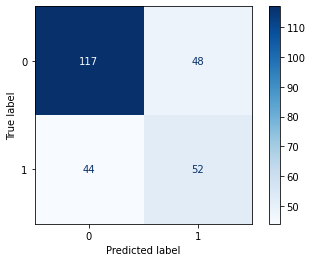

In [29]:
plot_confusion_matrix(DTclassifier, test_scaled, y_test,
                                 cmap=plt.cm.Blues,)

plt.show()

### XGBoost klasifikátor
Jeden z nejpopulárnějších modelů současnoti, pro tento případ overkill a přílíš málo trénovacích dat

In [30]:
#vypis parametru
params = {
        'n_estimators': stats.randint(50, 1000),
        'learning_rate': stats.uniform(0.01, 0.6),
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0,2],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [6,7,9,10,11,13]

        }
xgb = XGBClassifier()
#vyber nejlepsich parametru
rs = RandomizedSearchCV(xgb, param_distributions=params, n_iter=5, n_jobs=-1, cv=5, verbose=3, random_state=1001 )
#trenovani
rs.fit(train_scaled, y_train)

#predikce
y_pred = rs.best_estimator_.predict(test_scaled)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\mates\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.72489545 0.74116988 0.70343037        nan]
  warnings.warn(
C:\Users\mates\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:11:25] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [31]:
#výsledky
print(f'Accuracy: {accuracy_score(y_test,y_pred)*100:.2f}%')
print(f'Precision: {precision_score(y_test,y_pred)*100:.2f}%')
print(f'Recall: {recall_score(y_test,y_pred)*100:.2f}%')

Accuracy: 60.15%
Precision: 45.92%
Recall: 46.88%


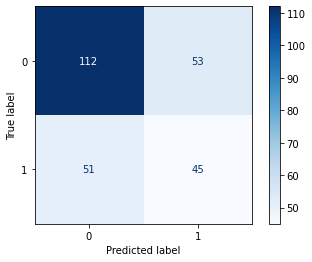

In [32]:
plot_confusion_matrix(rs.best_estimator_, test_scaled, y_test,
                                 cmap=plt.cm.Blues)

plt.show()

### Logistická regrese

In [33]:
LRclassifier = LogisticRegression(solver='liblinear', max_iter=5000)
#trénování
LRclassifier.fit(train_scaled, y_train)
#predikce
y_pred = LRclassifier.predict(test_scaled)
#výsledky
print(f'Accuracy: {accuracy_score(y_test,y_pred)*100:.2f}%')
print(f'Precision: {precision_score(y_test,y_pred)*100:.2f}%')
print(f'Recall: {recall_score(y_test,y_pred)*100:.2f}%')


Accuracy: 67.43%
Precision: 56.63%
Recall: 48.96%


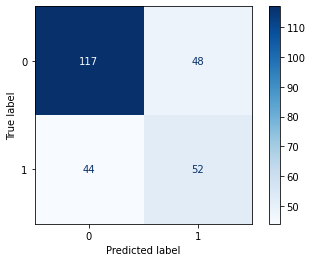

In [34]:
plot_confusion_matrix(DTclassifier, test_scaled, y_test,
                                 cmap=plt.cm.Blues,)

plt.show()

### Neuronová síť
neuronová síť se stejným vstupem jako předešlé modely

In [35]:
#vytvoření modelu, vstupní vrstvy, tří skrytých vrstev a jedné výstupní
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(len(X.columns),)),
  tf.keras.layers.Dense(32, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
#compilování modelu
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
               metrics=[
                       'accuracy'
              ])



In [36]:
#trénování neuronové sítě, ukončeno po 12 epochách(overfitting)
hist = model.fit(train_scaled, y_train,validation_data=(test_scaled, y_test), epochs=12,  shuffle = True)

Epoch 1/12
43/43 [==============================] - 0s 4ms/step - loss: 0.6811 - accuracy: 0.5658 - val_loss: 0.6725 - val_accuracy: 0.6475
Epoch 2/12
43/43 [==============================] - 0s 1ms/step - loss: 0.6601 - accuracy: 0.6198 - val_loss: 0.6708 - val_accuracy: 0.6398
Epoch 3/12
43/43 [==============================] - 0s 1ms/step - loss: 0.6463 - accuracy: 0.6309 - val_loss: 0.6449 - val_accuracy: 0.6820
Epoch 4/12
43/43 [==============================] - 0s 1ms/step - loss: 0.6439 - accuracy: 0.6509 - val_loss: 0.6400 - val_accuracy: 0.6858
Epoch 5/12
43/43 [==============================] - 0s 1ms/step - loss: 0.6443 - accuracy: 0.6553 - val_loss: 0.6430 - val_accuracy: 0.6820
Epoch 6/12
43/43 [==============================] - 0s 1ms/step - loss: 0.6407 - accuracy: 0.6405 - val_loss: 0.6330 - val_accuracy: 0.6858
Epoch 7/12
43/43 [==============================] - 0s 1ms/step - loss: 0.6257 - accuracy: 0.6649 - val_loss: 0.6332 - val_accuracy: 0.6820
Epoch 8/12
43/43 [==

#### Vyhodnocení
Dva grafy porovnávající přesnost a ztrátu pro trénovací a validační data

[]

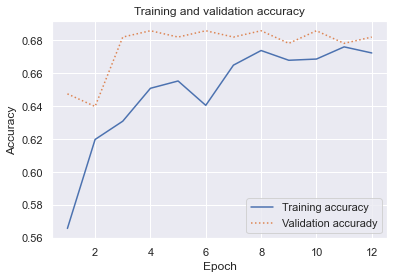

In [38]:
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accurady')

plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

[]

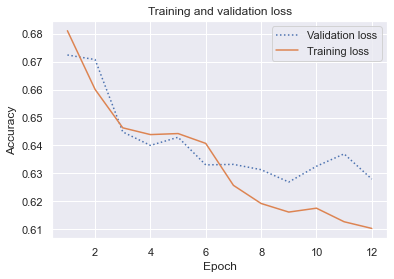

In [39]:
valLoss = hist.history['val_loss']
loss = hist.history['loss']

plt.plot(epochs, valLoss, ':', label='Validation loss')
plt.plot(epochs, loss, '-', label='Training loss')

plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.plot()

In [40]:
#převedení hodnot na celá čísla, vyhodnocení
y_sex = model.predict(test_scaled)
testCol = pd.DataFrame({'sex': y_sex[:, 0]})
testCol['sex'] = testCol['sex'].round(0).astype('int')
testCol

,sex
0,0
1,0
2,0
3,0
4,1
...,...
256,1
257,0
258,1
259,0


In [41]:
print(f'Accuracy: {accuracy_score(y_test,testCol)*100:.2f}%')
print(f'Precision: {precision_score(y_test,testCol)*100:.2f}%')
print(f'Recall: {recall_score(y_test,testCol)*100:.2f}%')

Accuracy: 68.20%
Precision: 57.47%
Recall: 52.08%


In [42]:
confusion_matrix(y_test,testCol)

array([[128,  37],
       [ 46,  50]], dtype=int64)

### Summary
Po delší úprávě parametrů dodala neuronová síť téměř stejné výsledky jako tradiční algoritmy. Přesnost téměř kopíruje nevybalancovanost datasetu, což i dokazuje daleko nižší precision a recall. V dalším kroku se tedy zaměříme na neuronovou síť s využitím Embedding vrstvy.

## Neuronová síť s využitím embeddings

In [44]:
#kopie původního datasetu, záměna hodnot za stringy pro demonstraci embedding layer
dfEmb['sex'] = dfEmb['sex'].replace({'female':1, 'male' : 0})
dfEmb['pclass'] = dfEmb['pclass'].replace({1 : 'first', 2 : 'second', 3 : 'third'})
dfEmb

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,first,yes,1,29.000000,0,0,211.3375,Southampton
1,first,yes,0,0.916700,1,2,151.5500,Southampton
2,first,no,1,2.000000,1,2,151.5500,Southampton
3,first,no,0,30.000000,1,2,151.5500,Southampton
4,first,no,1,25.000000,1,2,151.5500,Southampton
...,...,...,...,...,...,...,...,...
1304,third,no,1,14.500000,1,0,14.4542,Cherbourg
1305,third,no,1,29.881135,1,0,14.4542,Cherbourg
1306,third,no,0,26.500000,0,0,7.2250,Cherbourg
1307,third,no,0,27.000000,0,0,7.2250,Cherbourg


Definice cílové proměnné, splitnutí datasetu. Vybalancování trénovacích dat a následný split na numerické a kategorické features

In [45]:

X = dfEmb.drop('sex',axis =1)
y = dfEmb['sex']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=101)

ros = RandomOverSampler(sampling_strategy = "not majority")

X_train, y_train = ros.fit_resample(X_train,y_train)

c_inputs_train = X_train[['pclass','survived','embarked']]
n_inputs_train = X_train[['age','sibsp','parch','fare']]

c_inputs_test = X_test[['pclass','survived','embarked']]
n_inputs_test = X_test[['age','sibsp','parch','fare']]

#nastavení tresholdu pro přesnost neuronové sítě
acc_treshold = 0.75

Callback, který ukončí trénování sítě při dosažení přesnosti 75%, delší trénování vedlo k overfittingu a slabé výkonnosti/stagnaci modelu

In [46]:
#Třída, která hledá překročení hranice přesnosti modelu
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') is not None and logs.get('val_accuracy') >= acc_treshold):
            print("\nDosažení %2.2f%% přesnosti, další trénování povede k overfittingu." %(acc_treshold*100))
            self.model.stop_training = True

In [47]:
#zavolání třídy pro sledování hranice přesnosti
callbacks = myCallback()

#encodování kategorických proměnných
enc = OneHotEncoder(handle_unknown='error')
one_hot_encoded_cat_data_train = pd.DataFrame(enc.fit_transform(c_inputs_train).toarray())
one_hot_encoded_cat_data_test = pd.DataFrame(enc.fit_transform(c_inputs_test).toarray())


n_unique_cat  = len(np.unique(c_inputs_train))
#embedding size dle nepsaného pravidla 50, počet kategorií / 2
embedding_size = min(np.ceil((n_unique_cat)/2), 50 )
embedding_size = int(embedding_size)

# Specifikace input vrstev a velikost tvaru inputu
inp_cat_data = keras.layers.Input(shape=(n_unique_cat,))
inp_num_data = keras.layers.Input(shape=(n_inputs_train.shape[1],))

#vytvoření embedding vrstvy
emb = keras.layers.Embedding(input_dim=n_unique_cat, output_dim=embedding_size)(inp_cat_data)

#sploštěn tensoru aby byla možnost spojit jej s numerických imputem
flatten = keras.layers.Flatten()(emb)

#spojení numerických a kategorických inputů
conc = keras.layers.Concatenate()([flatten, inp_num_data])

#skryté vrstvy
dense1 = keras.layers.Dense(32, activation=tf.nn.relu, )(conc)
dense2 = keras.layers.Dense(64, activation=tf.nn.relu, )(conc)

#output vrstva, aktivační vrstva sigmoid pro binární klasifikaci
out = keras.layers.Dense(1, activation=tf.nn.sigmoid)(dense1)
model = keras.Model(inputs=[inp_cat_data, inp_num_data], outputs=out)

#compilace modelu
model.compile(optimizer=tf.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics='accuracy')

Trénování modelu, callback jej zastaví při dosažení přesnosti 75%, případně bude třénován pro 10 epoch, delší trénování způsobovalo overfitting

In [48]:
hist = model.fit([one_hot_encoded_cat_data_train, n_inputs_train], y_train,
          validation_data=([one_hot_encoded_cat_data_test, n_inputs_test], y_test), epochs=10, shuffle = True,callbacks=[callbacks])

Epoch 1/10
43/43 [==============================] - 0s 3ms/step - loss: 1.0278 - accuracy: 0.5380 - val_loss: 0.6719 - val_accuracy: 0.6603
Epoch 2/10
43/43 [==============================] - 0s 1ms/step - loss: 0.7042 - accuracy: 0.6080 - val_loss: 0.6287 - val_accuracy: 0.6679
Epoch 3/10
43/43 [==============================] - 0s 1ms/step - loss: 0.6481 - accuracy: 0.6343 - val_loss: 0.6016 - val_accuracy: 0.6947
Epoch 4/10
43/43 [==============================] - 0s 1ms/step - loss: 0.6097 - accuracy: 0.6912 - val_loss: 0.5694 - val_accuracy: 0.7405
Epoch 5/10
43/43 [==============================] - 0s 1ms/step - loss: 0.5494 - accuracy: 0.7438 - val_loss: 0.6170 - val_accuracy: 0.6947
Epoch 6/10
43/43 [==============================] - 0s 1ms/step - loss: 0.5305 - accuracy: 0.7599 - val_loss: 0.5331 - val_accuracy: 0.7405
Epoch 7/10
 1/43 [..............................] - ETA: 0s - loss: 0.4415 - accuracy: 0.8750
Reached 75.00% accuracy, so stopping training!!
43/43 [===========

#### Vyhodnocení
Stejné vyhodnocení neuronové sítě, dva grafy sledující přesnost a loss pro trénovací a validační data


[]

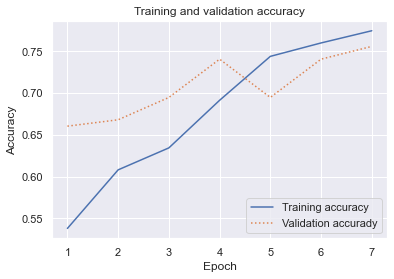

In [49]:
acc = hist.history['accuracy']
val = hist.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accurady')

plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

[]

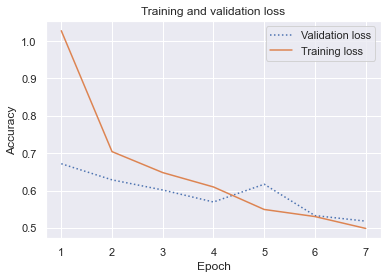

In [50]:
valLoss = hist.history['val_loss']
loss = hist.history['loss']

plt.plot(epochs, valLoss, ':', label='Validation loss')
plt.plot(epochs, loss, '-', label='Training loss')

plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.plot()

In [51]:
y_sex_Emb = model.predict([one_hot_encoded_cat_data_test, n_inputs_test])
y_sex_Emb

array([[0.76748466],
       [0.7183782 ],
       [0.5537022 ],
       [0.33092374],
       [0.6904426 ],
       [0.32782227],
       [0.5350534 ],
       [0.16071042],
       [0.2713688 ],
       [0.18118992],
       [0.79328036],
       [0.7432078 ],
       [0.17366424],
       [0.766252  ],
       [0.44000545],
       [0.16755515],
       [0.33257562],
       [0.745765  ],
       [0.6937133 ],
       [0.1955606 ],
       [0.8691571 ],
       [0.15063381],
       [0.35461354],
       [0.25472224],
       [0.16586888],
       [0.22604302],
       [0.82323545],
       [0.4856553 ],
       [0.82734716],
       [0.76712084],
       [0.822595  ],
       [0.09774974],
       [0.37033704],
       [0.6745218 ],
       [0.26074743],
       [0.3137005 ],
       [0.8275435 ],
       [0.7111152 ],
       [0.2246145 ],
       [0.70610607],
       [0.09753582],
       [0.63338923],
       [0.14767021],
       [0.17449316],
       [0.7372476 ],
       [0.76864684],
       [0.6801537 ],
       [0.792

In [52]:
testCol = pd.DataFrame({'sex': y_sex_Emb[:, 0]})
testCol['sex'] = testCol['sex'].round(0).astype('int')
testCol

,sex
0,1
1,1
2,1
3,0
4,1
...,...
257,0
258,0
259,0
260,0


In [53]:
print(f'Accuracy: {accuracy_score(y_test,testCol)*100:.2f}%')
print(f'Precision: {precision_score(y_test,testCol)*100:.2f}%')
print(f'Recall: {recall_score(y_test,testCol)*100:.2f}%')

Accuracy: 75.57%
Precision: 69.23%
Recall: 69.23%


In [54]:
confusion_matrix(y_test,testCol)

array([[126,  32],
       [ 32,  72]], dtype=int64)

#### Summary
Neuronová síť s využitím embeddings vrsty dodala lepší výsledky než předchozí modely, jelikož daleko lépe zachovává vztahy u kategorických proměnných.
I s relativně nízkým počtem trénovacích dat dosahuje model přesnosti 75% a zároveň i vysokých hodnot precision a recall. Lepší rozložení hodnot trénovacích dat, v porovnání s ostatními modely, je také vidět v matici záměn.

Využití embeddings vrstvy je tedy velký boost pro výkon neuronové sítě v případě, že pracujeme i s kategorickými daty.